In [ ]:
# ✅ STEP 1: Mount Drive and Import Libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
!pip install -q monai plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from monai.networks.nets import resnet
from monai.transforms import (
    Compose, RandRotate90, RandFlip, RandGaussianNoise, RandAdjustContrast, RandGaussianSmooth
)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
import plotly.express as px

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# STEP 2: Load Data
data = np.load("/content/drive/MyDrive/adrenalmnist3d_64.npz")
train_x, train_y = data['train_images'], data['train_labels']
val_x, val_y     = data['val_images'], data['val_labels']
test_x, test_y   = data['test_images'], data['test_labels']

In [ ]:
# STEP 3: Normalize
def normalize(img): return img.astype(np.float32) / 255.0

In [ ]:
# STEP 4: Define MONAI 3D augmentations
def get_monai_augmentor(name):
    if name == "rand":
        return Compose([
            RandAdjustContrast(prob=0.5, gamma=(0.7, 1.5)),
            RandGaussianNoise(prob=0.3),
        ])
    elif name == "cyclic":
        return Compose([
            RandRotate90(prob=0.5, spatial_axes=(1, 2)),
            RandFlip(prob=0.5, spatial_axis=0),
        ])
    elif name == "cyclic_ilr":
        return Compose([
            RandRotate90(prob=0.5, spatial_axes=(1, 2)),
            RandFlip(prob=0.5, spatial_axis=0),
            RandAdjustContrast(prob=0.5, gamma=(0.7, 1.5)),
            RandGaussianSmooth(prob=0.3),
        ])
    else:
        return None

In [ ]:
# STEP 5: Dataset with MONAI 3D augmentations
class Vessel3DDataset(Dataset):
    def __init__(self, images, labels, augmentor=None):
        self.images = images
        self.labels = labels
        self.aug = augmentor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = normalize(self.images[idx])  # (D,H,W), float32 normalized
        img = torch.tensor(img).unsqueeze(0)  # Add channel: (1,D,H,W)
        if self.aug:
            img = self.aug(img)  # MONAI expects torch tensor with channel-first
        y = torch.tensor(self.labels[idx]).long()
        return img, y

In [ ]:
# STEP 6: Evaluate + Metrics function
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            prob = F.softmax(out, dim=1)
            pred = torch.argmax(prob, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            y_prob.extend(prob[:, 1].cpu().numpy())
    return y_true, y_pred, y_prob

In [ ]:
# STEP 7: Train model function (15 epochs)
def train_model(name, train_aug):
    print(f"\n🔧 Training for: {name}")
    train_ds = Vessel3DDataset(train_x, train_y, get_monai_augmentor(train_aug))
    val_ds = Vessel3DDataset(val_x, val_y)
    test_ds = Vessel3DDataset(test_x, test_y)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=16)
    test_loader  = DataLoader(test_ds, batch_size=16)

    model = resnet.resnet50(spatial_dims=3, n_input_channels=1, num_classes=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(10):  # Increased epochs from 5 to 15
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
        for x, y in loop:
            x, y = x.to(device), y.to(device).view(-1)
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(out, dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct / total * 100)

        train_acc = correct / total * 100
        val_y_true, val_y_pred, _ = evaluate(model, val_loader)
        val_acc = (np.array(val_y_true) == np.array(val_y_pred)).mean() * 100

        print(f"📌 Epoch {epoch+1} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    y_true, y_pred, y_prob = evaluate(model, test_loader)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, output_dict=True)
    auc = roc_auc_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)

    return {
        "model": model,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "confusion_matrix": cm,
        "classification_report": cr,
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc
    }

In [ ]:

# STEP 8: Run all 4
results = {}
results["Original"]           = train_model("Original", None)
results["RandAugment"]        = train_model("RandAugment", "rand")
results["CyclicAugment"]      = train_model("CyclicAugment", "cyclic")
results["CyclicAugment+ILR"]  = train_model("CyclicAugment+ILR", "cyclic_ilr")


🔧 Training for: Original


📌 Epoch 1 | Loss: 36.7159 | Train Acc: 77.86% | Val Acc: 76.43%


📌 Epoch 2 | Loss: 30.4929 | Train Acc: 84.09% | Val Acc: 37.07%


📌 Epoch 3 | Loss: 28.6478 | Train Acc: 83.92% | Val Acc: 70.24%


📌 Epoch 4 | Loss: 26.7582 | Train Acc: 84.76% | Val Acc: 58.43%


📌 Epoch 5 | Loss: 23.4165 | Train Acc: 86.95% | Val Acc: 38.19%


📌 Epoch 6 | Loss: 23.2244 | Train Acc: 86.53% | Val Acc: 76.99%


📌 Epoch 7 | Loss: 23.8890 | Train Acc: 87.12% | Val Acc: 74.74%


📌 Epoch 8 | Loss: 18.4452 | Train Acc: 90.15% | Val Acc: 73.62%


📌 Epoch 9 | Loss: 25.2596 | Train Acc: 86.70% | Val Acc: 44.38%


📌 Epoch 10 | Loss: 19.4130 | Train Acc: 89.65% | Val Acc: 67.43%

🔧 Training for: RandAugment


📌 Epoch 1 | Loss: 35.8082 | Train Acc: 79.21% | Val Acc: 73.62%


📌 Epoch 2 | Loss: 32.0840 | Train Acc: 82.07% | Val Acc: 31.45%


📌 Epoch 3 | Loss: 27.0771 | Train Acc: 85.19% | Val Acc: 37.63%


📌 Epoch 4 | Loss: 25.2916 | Train Acc: 86.11% | Val Acc: 65.74%


📌 Epoch 5 | Loss: 26.9255 | Train Acc: 85.27% | Val Acc: 39.88%


📌 Epoch 6 | Loss: 25.4495 | Train Acc: 84.85% | Val Acc: 70.80%


📌 Epoch 7 | Loss: 19.7232 | Train Acc: 89.56% | Val Acc: 58.43%


📌 Epoch 8 | Loss: 20.9069 | Train Acc: 88.05% | Val Acc: 59.56%


📌 Epoch 9 | Loss: 19.2184 | Train Acc: 89.56% | Val Acc: 59.00%


📌 Epoch 10 | Loss: 20.2965 | Train Acc: 89.39% | Val Acc: 55.62%

🔧 Training for: CyclicAugment


📌 Epoch 1 | Loss: 37.5657 | Train Acc: 78.87% | Val Acc: 48.88%


📌 Epoch 2 | Loss: 32.9069 | Train Acc: 81.31% | Val Acc: 70.80%


📌 Epoch 3 | Loss: 32.4949 | Train Acc: 81.57% | Val Acc: 56.75%


📌 Epoch 4 | Loss: 30.1698 | Train Acc: 82.66% | Val Acc: 58.43%


📌 Epoch 5 | Loss: 29.9578 | Train Acc: 83.50% | Val Acc: 35.38%


📌 Epoch 6 | Loss: 29.6354 | Train Acc: 82.74% | Val Acc: 72.49%


📌 Epoch 7 | Loss: 31.6816 | Train Acc: 81.14% | Val Acc: 46.06%


📌 Epoch 8 | Loss: 28.4422 | Train Acc: 83.25% | Val Acc: 72.49%


📌 Epoch 9 | Loss: 29.0768 | Train Acc: 83.50% | Val Acc: 77.55%


📌 Epoch 10 | Loss: 27.1942 | Train Acc: 85.19% | Val Acc: 67.99%

🔧 Training for: CyclicAugment+ILR


📌 Epoch 1 | Loss: 38.4310 | Train Acc: 78.79% | Val Acc: 71.37%


📌 Epoch 2 | Loss: 33.8207 | Train Acc: 80.39% | Val Acc: 56.18%


📌 Epoch 3 | Loss: 31.9898 | Train Acc: 81.99% | Val Acc: 72.49%


📌 Epoch 4 | Loss: 32.6294 | Train Acc: 80.98% | Val Acc: 75.86%


📌 Epoch 5 | Loss: 31.6115 | Train Acc: 81.14% | Val Acc: 62.37%


📌 Epoch 6 | Loss: 29.5912 | Train Acc: 83.84% | Val Acc: 64.06%


📌 Epoch 7 | Loss: 29.5024 | Train Acc: 83.50% | Val Acc: 70.24%


📌 Epoch 8 | Loss: 30.3492 | Train Acc: 82.49% | Val Acc: 70.24%


📌 Epoch 9 | Loss: 29.8413 | Train Acc: 81.65% | Val Acc: 62.37%


📌 Epoch 10 | Loss: 27.9931 | Train Acc: 84.09% | Val Acc: 50.00%


In [ ]:
# STEP 9: Summary Table
table = pd.DataFrame([
    {
        "Setup": name,
        "Precision (Class 1)": f"{res['classification_report']['1']['precision']:.2f}",
        "Recall (Class 1)": f"{res['classification_report']['1']['recall']:.2f}",
        "F1 (Class 1)": f"{res['classification_report']['1']['f1-score']:.2f}",
        "ROC AUC": f"{res['auc']:.2f}"
    } for name, res in results.items()
])
print("\n📊 Metrics Summary:\n", table)


📊 Metrics Summary:
                Setup Precision (Class 1) Recall (Class 1) F1 (Class 1) ROC AUC
0           Original                0.62             0.48         0.54    0.83
1        RandAugment                0.49             0.83         0.61    0.84
2      CyclicAugment                0.75             0.39         0.51    0.89
3  CyclicAugment+ILR                0.48             0.88         0.62    0.87


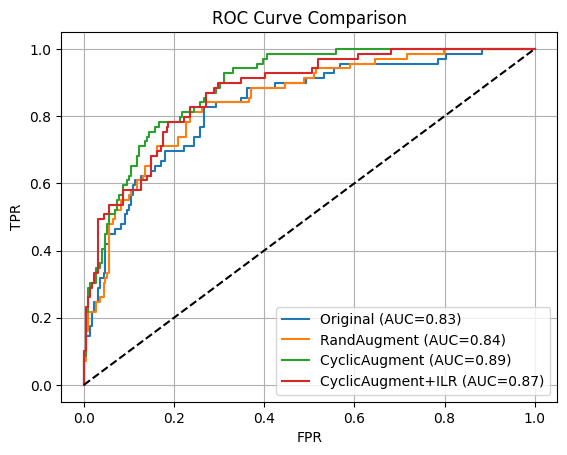

In [ ]:
# STEP 10: ROC Curve Plot
for name, res in results.items():
    plt.plot(res["fpr"], res["tpr"], label=f"{name} (AUC={res['auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# ✅ Re-define test_set (no augmentations, just normalization)
test_set = Vessel3DDataset(test_x, test_y)  # No augmentation


🧠 🔎 Random Sample Prediction for test index: 23
🔹 Ground Truth Label: Diseased (1)



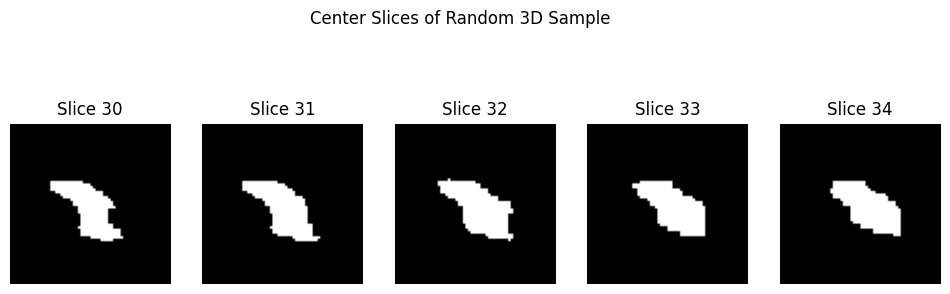

🔸 Original → Predicted: 1 — ✅ Correct ✅
🔸 RandAugment → Predicted: 1 — ✅ Correct ✅
🔸 CyclicAugment → Predicted: 0 — ❌ Wrong ❌
🔸 CyclicAugment+ILR → Predicted: 1 — ✅ Correct ✅


In [ ]:
# STEP 12: Random Sample Prediction + Visualization (for all 4 models)
idx = np.random.randint(len(test_set))
x, y = test_set[idx]  # x shape: (1, D, H, W)
x_display = x.squeeze(0).cpu().numpy()  # shape: (D, H, W)
x_input = x.unsqueeze(0).to(device)
y = y.item()
class_names = {0: "Healthy", 1: "Diseased"}
true_label_name = class_names[y]

print(f"\n🧠 🔎 Random Sample Prediction for test index: {idx}")
print(f"🔹 Ground Truth Label: {true_label_name} ({y})\n")

# Plot center slices of the sample
num_slices = x_display.shape[0]
center_slice = num_slices // 2

plt.figure(figsize=(12, 4))
for i, offset in enumerate([-2, -1, 0, 1, 2]):
    slice_idx = center_slice + offset
    if 0 <= slice_idx < num_slices:
        plt.subplot(1, 5, i + 1)
        plt.imshow(x_display[slice_idx], cmap='gray')
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')
plt.suptitle("Center Slices of Random 3D Sample")
plt.show()

# Loop through each model and show prediction
for name, res in results.items():
    model = res["model"]
    model.eval()

    with torch.no_grad():
        out = model(x_input)
        pred = out.argmax(1).item()

    verdict = "✅ Correct ✅" if pred == y else "❌ Wrong ❌"
    print(f"🔸 {name} → Predicted: {pred} — {verdict}")



In [ ]:
import plotly.express as px

fig = px.imshow(x_display,
                animation_frame=0,
                binary_string=True,
                color_continuous_scale='gray')
fig.update_layout(title="3D Image Slices",
                  coloraxis_showscale=False)
fig.show()

In [ ]:

print("\n✅ Overall Accuracy for Each Setup:")
for name, res in results.items():
    y_true = np.array(res["y_true"])
    y_pred = np.array(res["y_pred"])
    accuracy = (y_true == y_pred).mean() * 100
    print(f"🔹 {name}: {accuracy:.2f}%")


✅ Overall Accuracy for Each Setup:
🔹 Original: 67.30%
🔹 RandAugment: 55.77%
🔹 CyclicAugment: 70.36%
🔹 CyclicAugment+ILR: 53.78%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.



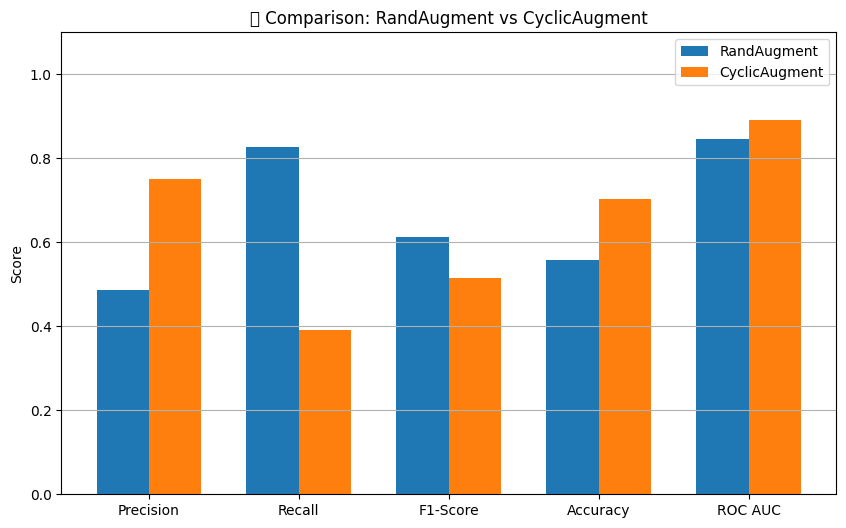

In [ ]:

# ✅ Bar Chart Comparison: RandAugment vs CyclicAugment
labels = ["Precision", "Recall", "F1-Score", "Accuracy", "ROC AUC"]

rand = results["RandAugment"]
cyclic = results["CyclicAugment"]

rand_metrics = [
    rand["classification_report"]["1"]["precision"],
    rand["classification_report"]["1"]["recall"],
    rand["classification_report"]["1"]["f1-score"],
    (np.array(rand["y_true"]) == np.array(rand["y_pred"])).mean(),
    rand["auc"]
]

cyclic_metrics = [
    cyclic["classification_report"]["1"]["precision"],
    cyclic["classification_report"]["1"]["recall"],
    cyclic["classification_report"]["1"]["f1-score"],
    (np.array(cyclic["y_true"]) == np.array(cyclic["y_pred"])).mean(),
    cyclic["auc"]
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rand_metrics, width, label='RandAugment')
plt.bar(x + width/2, cyclic_metrics, width, label='CyclicAugment')
plt.xticks(x, labels)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("🔍 Comparison: RandAugment vs CyclicAugment")
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
torch.save(model.state_dict(), f"/content/drive/MyDrive/{name}_resnet50_adrenal3d.pth")
print(f"✅ Model saved: {name}_resnet50_adrenal3d.pth")


In [ ]:
import matplotlib.pyplot as plt

def show_two_samples(test_set, results, device):
    # Find one healthy and one diseased sample index
    healthy_idx = None
    diseased_idx = None

    for i in range(len(test_set)):
        _, label = test_set[i]
        if label.item() == 0 and healthy_idx is None:
            healthy_idx = i
        if label.item() == 1 and diseased_idx is None:
            diseased_idx = i
        if healthy_idx is not None and diseased_idx is not None:
            break

    # Prepare samples
    samples = {
        "Healthy": test_set[healthy_idx][0].squeeze(0).cpu().numpy(),
        "Diseased": test_set[diseased_idx][0].squeeze(0).cpu().numpy()
    }

    # Plot center slices side by side
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Center 5 slices of Healthy vs Diseased Samples", fontsize=16)

    for row, (status, volume) in enumerate(samples.items()):
        num_slices = volume.shape[0]
        center_slice = num_slices // 2
        for col, offset in enumerate([-2, -1, 0, 1, 2]):
            slice_idx = center_slice + offset
            if 0 <= slice_idx < num_slices:
                axes[row, col].imshow(volume[slice_idx], cmap='gray')
                axes[row, col].set_title(f"{status}\nSlice {slice_idx}")
                axes[row, col].axis('off')
            else:
                axes[row, col].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show model predictions for these two samples for all setups
    for name, res in results.items():
        model = res["model"]
        model.eval()

        with torch.no_grad():
            for status, idx in zip(["Healthy", "Diseased"], [healthy_idx, diseased_idx]):
                x, y = test_set[idx]
                x_input = x.unsqueeze(0).to(device)
                out = model(x_input)
                pred = out.argmax(1).item()
                verdict = "✅ Correct ✅" if pred == y.item() else "❌ Wrong ❌"
                print(f"🔸 {name} Model Prediction on {status} sample: {pred} — {verdict}")

# Call this function after you have 'test_set' and 'results' ready
show_two_samples(test_set, results, device)
